# Running models on TLR activators not included in the original set

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
from adjustText import adjust_text
from sklearn.pipeline import Pipeline
from feature_engine.selection import DropDuplicateFeatures
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectKBest, chi2, SelectFromModel
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from pathlib import Path
from datetime import datetime
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import classification_report
from tqdm import tqdm
import time

from sklearn.metrics import (
    make_scorer,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    accuracy_score,
)

In [3]:
from sklearn.model_selection import StratifiedShuffleSplit
from joblib import parallel_backend

In [4]:
pd.set_option("display.max_columns", 20)
pd.set_option("display.max_rows", 400)
pd.set_option("display.precision", 5)
pd.set_option("display.max_seq_items", 50)
pd.set_option("display.max_seq_items", 50)

In [ ]:
custom_palette_6 = [
    "#1f77b4",  # Muted Blue
    "#ff7f0e",  # Soft Orange
    "#2ca02c",  # Green
    "#d62728",  # Red
    "#9467bd",  # Purple
    "#17becf",  # Teal/Cyan
]

custom_palette_8 = [
    "#1f77b4",  # Muted Blue
    "#ff7f0e",  # Soft Orange
    "#2ca02c",  # Green
    "#d62728",  # Red
    "#9467bd",  # Purple
    "#17becf",  # Teal/Cyan
    "#8c564b",  # Brown
    "#e377c2",  # Pink
    "#bcbd22",  # Yellow-Green
]
custom_palette_9 = [
    "#1f77b4",  # Muted Blue
    "#ff7f0e",  # Soft Orange
    "#2ca02c",  # Green
    "#d62728",  # Red
    "#9467bd",  # Purple
    "#17becf",  # Teal/Cyan
    "#8c564b",  # Brown
    "#00fa9a",  # Medium Spring Green
    "#ff00ff",  # Fuchsia
]

custom_palette_15 = [
    "#a0522d",  # Sienna
    "#006400",  # Dark Green
    "#778899",  # Light Slate Gray
    "#4b0082",  # Indigo
    "#ff0000",  # Red
    "#ffa500",  # Orange
    "#ffff00",  # Yellow
    "#00ff00",  # Lime
    "#00fa9a",  # Medium Spring Green
    "#00ffff",  # Aqua
    "#0000ff",  # Blue
    "#ff00ff",  # Fuchsia
    "#1e90ff",  # Dodger Blue
    "#eee8aa",  # Pale Goldenrod
    "#ff69b4",  # Hot Pink
]

## Custom functions

In [6]:
p = Path().cwd().parent
date = datetime.today().strftime("%Y%m%d")[2:]  # Get shortened year
RESULTS_PATH = p / f"{date}_output"
print(RESULTS_PATH)
RESULTS_PATH.mkdir(parents=True, exist_ok=True)


def save_fig(fig_name, tight_layout=True, fig_extension="png", resolution=300):
    """Save figure in png."""
    path = RESULTS_PATH / f"{fig_name}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)


def save_csv(table, table_name):
    """Save table in csv."""
    path = RESULTS_PATH / f"{table_name}.csv"
    table.to_csv(path)

/home/t.afanasyeva/MAT_rnaseq/250624_output


In [7]:
def get_confusion_matrix(y_test, y_pred, model_name):
    fig, ax = plt.subplots(figsize=(8, 8))
    ConfusionMatrixDisplay.from_predictions(
        y_test,
        y_pred,
        ax=ax,
        xticks_rotation="vertical",
        colorbar=False,
        normalize="true",
        values_format=".0%",
    )
    ax.set_title(f"Confusion Matrix {model_name}")
    plt.tight_layout()
    # save_fig(f"Confusion_Matrix_{name}")
    plt.show()

In [8]:
def make_probability_matrix(model_name, test_pred):
    plt.figure(figsize=(12, 8))

    g = sns.heatmap(test_pred, cmap="YlGnBu")
    g.set_title(f"{model_name} predictions", fontsize=15)
    g.set_xlabel("Reference", fontsize=15)
    g.set_ylabel("Sample", fontsize=15, labelpad=10)
    # heat.set_xticklabels(["Negative Control", "Positive Control", "Heat Killed Bacteria"], fontsize=12)
    plt.tight_layout()
    save_fig(f"{model_name}_TLR_predictions")
    plt.show()

    return g

In [9]:
class LibraryLengthNormalizer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        # Normalise the gene counts to the library size
        X = X.apply(lambda x: (x / (x.sum() if x.sum() != 0 else 1)) * 1000000, axis=1)
        return X


en = ExtraTreesClassifier(n_estimators=250, max_depth=5, random_state=42)

pipe = Pipeline(
    [
        (
            "drop_duplicates",
            DropDuplicateFeatures(),
        ),
        ("normalise_for_library_size", LibraryLengthNormalizer()),
        ("select_k_best", SelectKBest(chi2, k=1000)),
        ("select_forest", SelectFromModel(en, threshold=0.001, max_features=250)),
        ("standard_scale", StandardScaler()),
    ]
)
le = LabelEncoder()

## Load in data

In [10]:
file_path_multiindex = p / "resources/250624_training_multindex_108_7128.csv"
data_wi = pd.read_csv(file_path_multiindex, index_col=[0, 1])
labels = data_wi.index.get_level_values("label").to_numpy()
labels = np.where(labels == "IMDM", "negative_control", labels)
data = data_wi.copy()
data.reset_index(drop=True, inplace=True)

processed_data = pipe.fit_transform(data, labels)
labels_int = le.fit_transform(labels)

In [11]:
test_data = pd.read_csv(p / "resources/250624_300.csv", index_col=0)

CRX-527 acivates TLR-4 (as LPS), LTA activates TLR2 (in part like Pam3, which activates both TLR-1 and TLR-2), CL307 activates TLR7 (in part as R848, which activates TLR-7 and TLR-8).

In [ ]:
test_labels = [i.split("_")[2] for i in test_data.index]
test_data["label"] = test_labels
test_data = test_data.loc[test_data["label"].isin(["LTA", "Pam2", "MPLA"])]

test_labels = test_data.index.str.extract(r"(LTA|Pam2|MPLA)", expand=False).to_numpy()

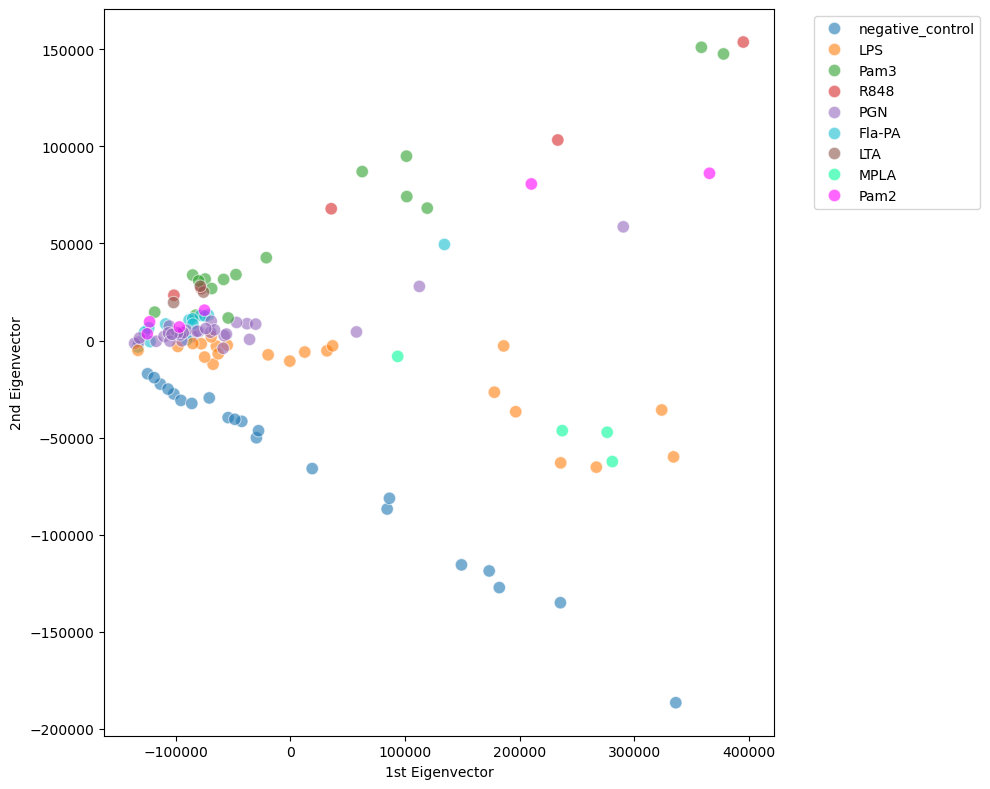

In [13]:
data_merged = pd.concat([data, test_data.drop(columns="label")], axis=0)
labels_merged = np.concatenate([labels, test_data["label"].to_numpy()])

X_reduced = PCA(n_components=2).fit_transform(data_merged)

fig = plt.figure(figsize=(10, 8))

ax = sns.scatterplot(
    x=X_reduced[:, 0],
    y=X_reduced[:, 1],
    hue=labels_merged,
    s=80,
    alpha=0.6,
    palette=custom_palette_9,
)

ax.set_xlabel("1st Eigenvector")
ax.set_ylabel("2nd Eigenvector")
ax.legend(bbox_to_anchor=(1.05, 1), loc="upper left", ncol=1)
plt.tight_layout()
save_fig("PCA_with_TLRs")
plt.show()

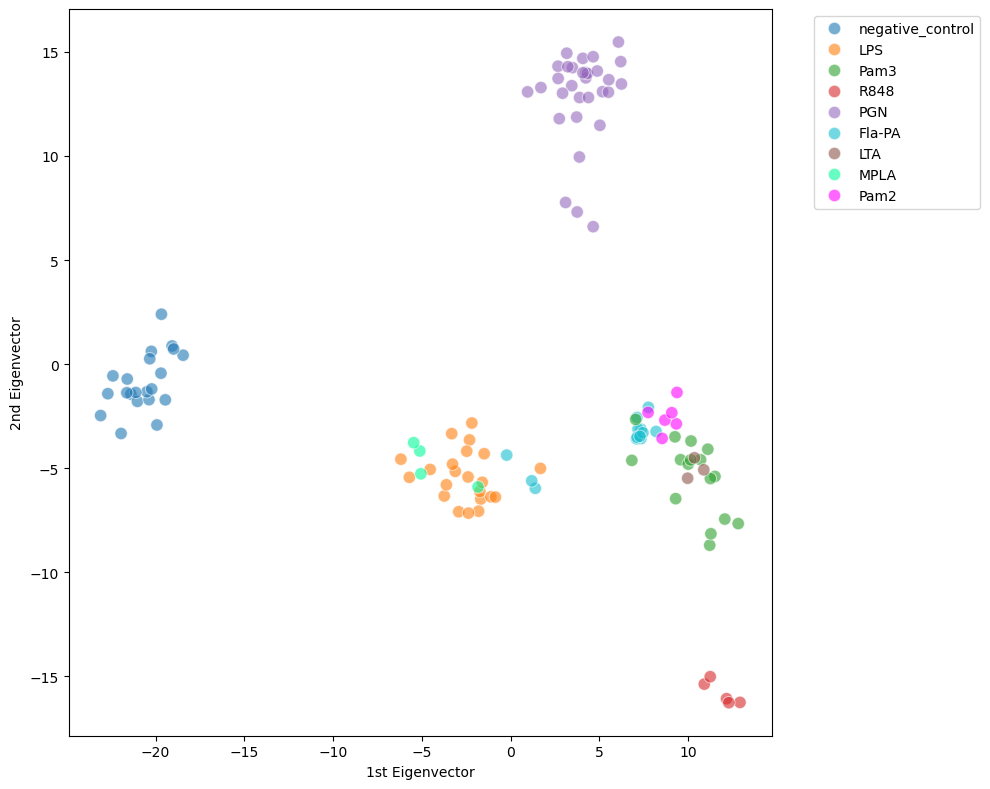

In [14]:
processed_test_data = pipe.transform(test_data.drop(columns="label"))

data_merged = np.concatenate([processed_data, processed_test_data], axis=0)
labels_merged = np.concatenate([labels, test_data["label"].to_numpy()])

X_reduced = PCA(n_components=2).fit_transform(data_merged)

fig = plt.figure(figsize=(10, 8))


ax = sns.scatterplot(
    x=X_reduced[:, 0],
    y=X_reduced[:, 1],
    hue=labels_merged,
    s=80,
    alpha=0.6,
    palette=custom_palette_9,
)

ax.set_xlabel("1st Eigenvector")
ax.set_ylabel("2nd Eigenvector")
ax.legend(bbox_to_anchor=(1.05, 1), loc="upper left", ncol=1)
plt.tight_layout()
save_fig("PCA_with_TLRs_postpipe")
plt.show()

In [15]:
random_state = np.random.RandomState(42)

svc = SVC(
    kernel="linear", probability=False, class_weight=None, random_state=random_state
)
svc = CalibratedClassifierCV(svc)
sgd = SGDClassifier(
    loss="modified_huber", early_stopping=True, random_state=random_state
)
rfc = RandomForestClassifier(
    max_depth=5, n_estimators=500, random_state=random_state, class_weight=None
)

models = {
    "LinearSVC": svc,
    "SGDClassifier": sgd,
    "RandomForestClassifier": rfc,
}

In [16]:
def multiclass_roc_auc_score(y_test, y_pred, average="macro") -> float:
    """Returns averaged auc per class"""
    unique_classes = set(y_test)
    roc_auc_dict = {}

    for tested_class in unique_classes:
        other_classes = [x for x in unique_classes if x != tested_class]

        # Marking the current class as 1 and all other classes as 0
        binary_y_test = [0 if x in other_classes else 1 for x in y_test]
        binary_y_pred = [0 if x in other_classes else 1 for x in y_pred]

        roc_auc = roc_auc_score(binary_y_test, binary_y_pred, average=average)

        roc_auc_dict[tested_class] = roc_auc

    return sum(roc_auc_dict.values()) / len(roc_auc_dict.values())


def make_score(y_test, y_pred) -> zip:
    accuracy, precision, recall, f1, roc_auc = (
        accuracy_score(y_test, y_pred),
        precision_score(y_test, y_pred, average="macro", zero_division=np.nan),
        recall_score(y_test, y_pred, average="macro", zero_division=np.nan),
        f1_score(y_test, y_pred, average="macro", zero_division=np.nan),
        multiclass_roc_auc_score(y_test, y_pred),
    )

    score_names = ["accuracy", "precision", "recall", "f1", "roc_auc"]
    return zip(score_names, (accuracy, precision, recall, f1, roc_auc))

In [17]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(sampling_strategy="not majority", k_neighbors=1)

## Train models

In [18]:
random_state = np.random.RandomState(42)

# Assuming 'LPS' and 'negative_control' are labels in the index
lps_sample = data_wi.loc[data_wi.index.get_level_values("label") == "LPS"].sample(
    n=1, random_state=random_state
)
negative_control_sample = data_wi.loc[
    data_wi.index.get_level_values("label") == "IMDM"
].sample(n=1, random_state=random_state)

data_wi = data_wi.drop(lps_sample.index)
data_wi = data_wi.drop(negative_control_sample.index)

negative_control_sample.reset_index(drop=True, inplace=True)
lps_sample.reset_index(drop=True, inplace=True)

len(data_wi)
processed_negative_control_sample = pipe.transform(negative_control_sample)
processed_lps_sample = pipe.transform(lps_sample)

Finished SMOTE


  0%|          | 0/3 [00:00<?, ?it/s]

Processing LinearSVC


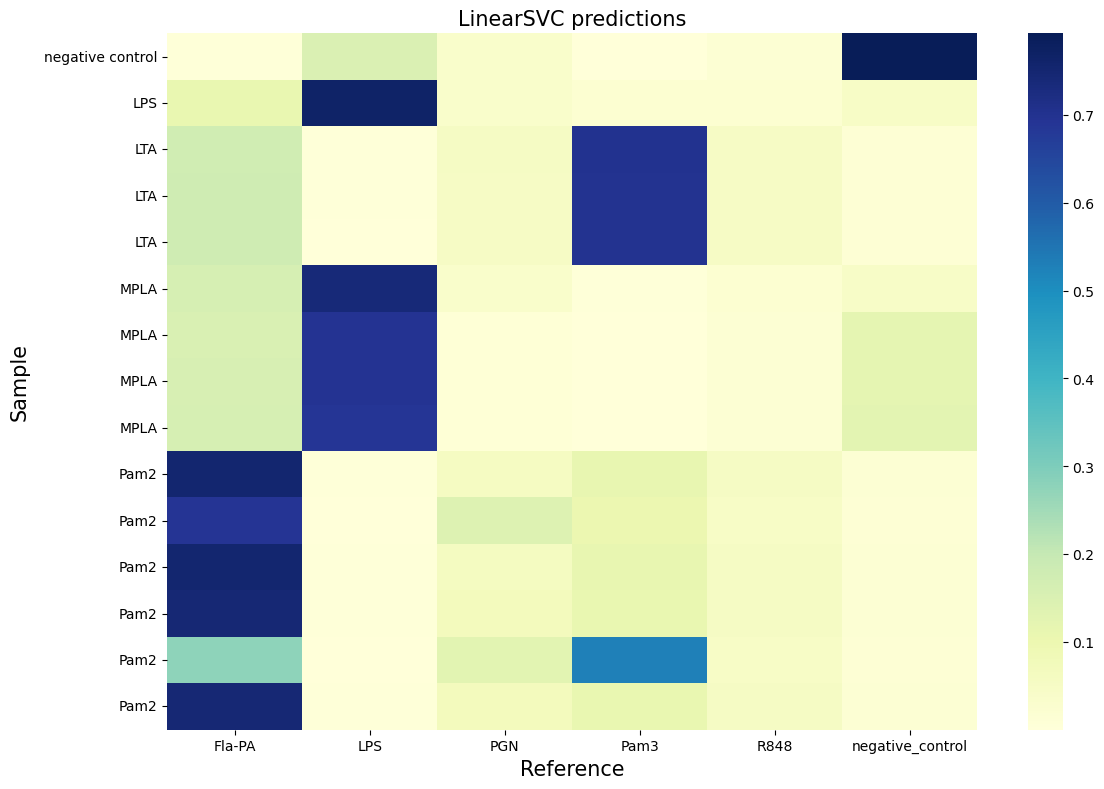

 33%|███▎      | 1/3 [00:00<00:01,  1.14it/s]

Processing SGDClassifier


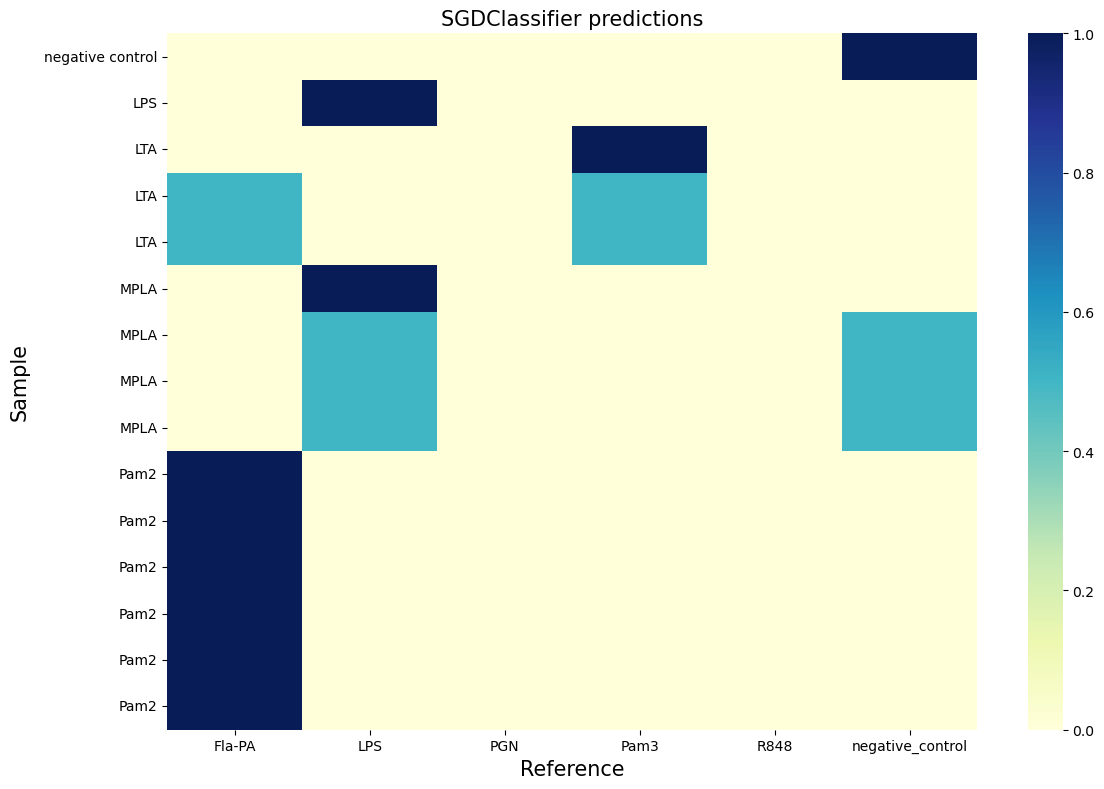

 67%|██████▋   | 2/3 [00:01<00:00,  1.17it/s]

Processing RandomForestClassifier


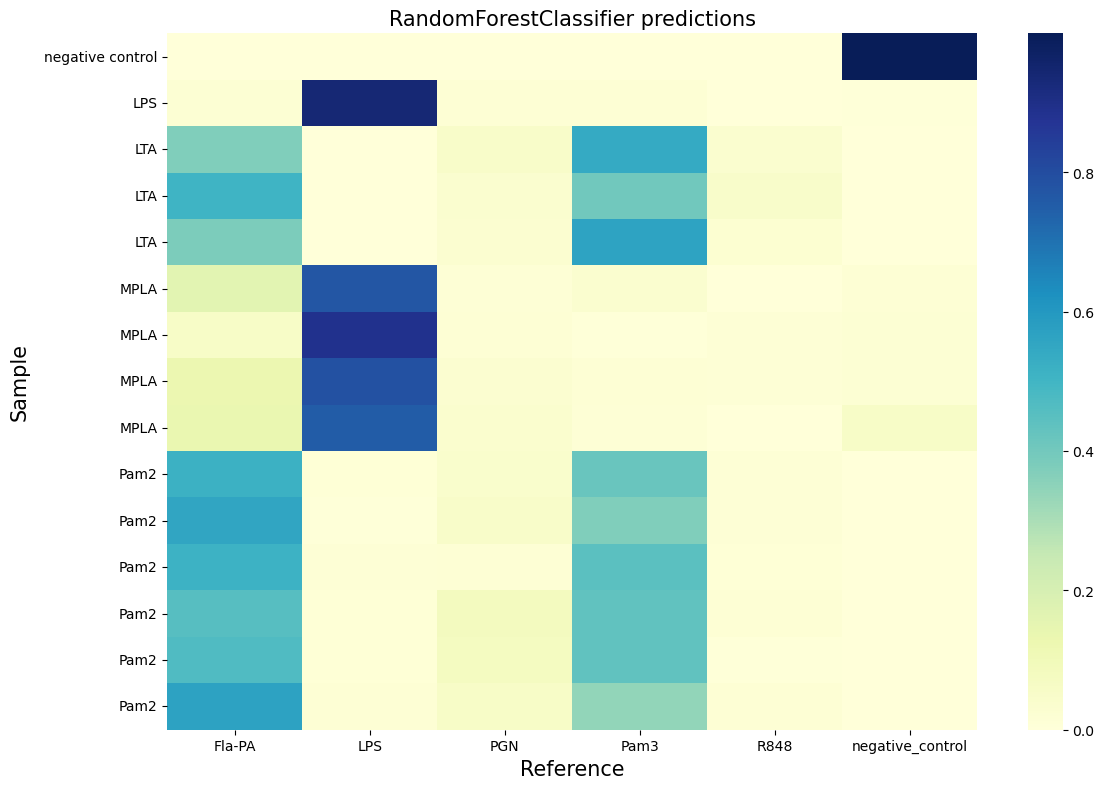

100%|██████████| 3/3 [00:03<00:00,  1.32s/it]


In [ ]:
results = []

X_test = processed_test_data
y_test = test_data["label"].to_numpy()

with parallel_backend("threading", n_jobs=42):
    X_train, y_train = sm.fit_resample(processed_data, labels)

    if not isinstance(X_train, np.ndarray):
        X_train = X_train.to_numpy()

    y_train = le.fit_transform(y_train)

    print("Finished SMOTE")

    for model_name, model in tqdm(models.items()):
        print(f"Processing {model_name}")
        start_time = time.time()
        model.fit(X_train, y_train)

        y_pred_negative_control = model.predict_proba(processed_negative_control_sample)
        y_pred_positive_control = model.predict_proba(processed_lps_sample)
        y_pred = model.predict_proba(X_test)

        test_pred = pd.DataFrame(
            np.vstack([y_pred_negative_control, y_pred_positive_control, y_pred]),
            columns=le.classes_,
            index=["negative control", "LPS", *test_labels],
        )
        make_probability_matrix(model_name, test_pred)